In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.optim import Adam
from tqdm import tqdm
from dotenv import load_dotenv

from transformers import RobertaModel, RobertaTokenizer
from torch.utils.data.sampler import WeightedRandomSampler
from triagerx.model.code_roberta import CodeRobertaClassifier

In [2]:
torch.cuda.is_available()

True

In [3]:
load_dotenv()

True

In [4]:
wandb.login()

wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


True

In [5]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [6]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 0) -> pd.DataFrame:
    developers = df["assignees"].value_counts()
    df = df[df["assignees"].notna()]
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: "Title: " + str(x["issue_title"]) + "\nDescription: " + str(x["issue_body"]), axis=1)
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

In [7]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated_cleaned.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df, minimum_contribution=5)
df = clean_data(df)

In [8]:
len(df["assignees"].unique())

47

In [9]:
print(len(df))

5103


<Axes: xlabel='assignees'>

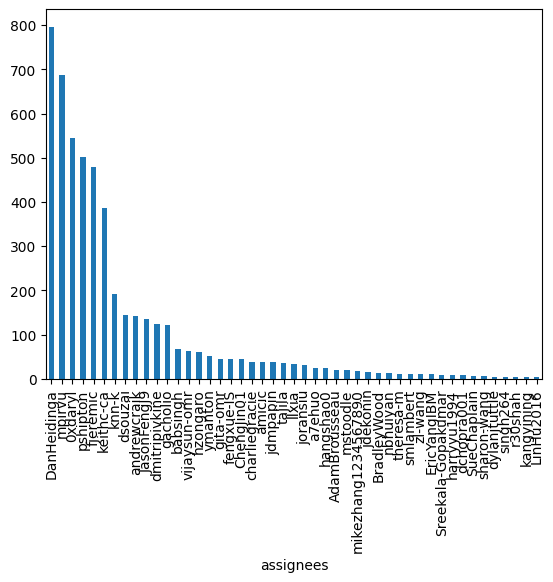

In [10]:
df["assignees"].value_counts().plot(kind="bar")

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
np.random.seed(42)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["owner_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.15, stratify=train_df["owner_id"])

In [13]:
assert len(train_df.owner_id.unique()) == len(train_df.owner_id.unique()) == len(valid_df.owner_id.unique())

In [14]:
# counts = np.bincount(X_train["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[X_train["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

In [15]:
import re

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, text_tokenizer, code_tokenizer):
        self.tokenizer = text_tokenizer
        self.labels = [label for label in df['owner_id']]
        self.texts = [(self.tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt"), code_tokenizer(self.get_code_if_exists(text),
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")) for text in df['text']]

    def classes(self):
        return self.labels
    

    def get_code_if_exists(self, text):
        if type(text) == str:
            code_blocks = re.findall(r'```([\s\S]+?)```', text)

            if len(code_blocks) > 0:
                return "\n".join(code_blocks)
            
            return ""
        
        return ""

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [16]:
learning_rate = 1e-6
epochs = 50
batch_size = 15

num_classes = len(df["assignees"].unique())
model = CodeRobertaClassifier(num_classes)
text_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
code_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# Create sampler
counts = np.bincount(train_df["owner_id"])
labels_weights = 1. / counts
weights = labels_weights[train_df["owner_id"]]
sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"

output_file = f"_{5}_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    }
}

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def train(model, tokenizer, code_tokenizer, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data, tokenizer, code_tokenizer), Dataset(val_data, tokenizer, code_tokenizer)

    wandb.init(**wandb_config)
    
    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
        # sampler=sampler
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    best_loss = float("inf")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        print("Using CUDA...")
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        print(f"Epoch: {epoch_num}")
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            
            text_input_id = train_input[0]["input_ids"].squeeze(1).to(device)
            text_mask = train_input[0]["attention_mask"].to(device)

            code_input_id = train_input[1]["input_ids"].squeeze(1).to(device)
            code_mask = train_input[1]["attention_mask"].to(device)

            output = model(text_input_id, text_mask, code_input_id, code_mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                
                text_input_id = val_input[0]["input_ids"].squeeze(1).to(device)
                text_mask = val_input[0]["attention_mask"].to(device)

                code_input_id = val_input[1]["input_ids"].squeeze(1).to(device)
                code_mask = val_input[1]["attention_mask"].to(device)

                output = model(text_input_id, text_mask, code_input_id, code_mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        val_loss = total_loss_val / len(val_data)

        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        print(log)

        wandb.log({
            "train_acc": total_acc_train / len(train_data), 
            "train_loss": total_loss_train / len(train_data),
            "val_acc": total_acc_val / len(val_data),
            "val_loss": total_loss_val / len(val_data)
            })

        if val_loss < best_loss:
            print("Found new best model. Saving weights...")
            torch.save(model.state_dict(), out_file)
            best_loss = val_loss
    
    wandb.finish()

train(model, text_tokenizer, code_tokenizer, train_df, valid_df, learning_rate, epochs)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Using CUDA...
Epoch: 0


 39%|███▉      | 96/246 [01:02<01:38,  1.53it/s]

In [ ]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

# Load Saved Model

In [ ]:
num_classes = len(df["assignees"].unique())
model = Classifier("roberta-base", num_classes, 768)
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/no_strat_imbalanced_5.pt"))
model = model.cuda()
text_tokenizer = model.tokenizer()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import random

y_preds = []

for i in range(len(X_test)):
    # rand = random.randint(0, len(df_val))
    dx = X_test.iloc[i]

    data = text_tokenizer(dx["text"], padding='max_length', max_length = 512, truncation=True)
    ids, mask = data["input_ids"], data["attention_mask"]

    id = torch.tensor([ids]).cuda()
    m = torch.tensor([mask]).cuda()

    g = nn.Softmax(dim=1)

    with torch.no_grad():
        y_pred = g(model(id, m))
        
    y_preds.append(y_pred)

In [ ]:
y_true = X_test["owner_id"].to_numpy()

In [ ]:
sorted(X_test["owner_id"].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [ ]:
y_numpy = []

for y in y_preds:
    y_numpy.append(y.cpu().numpy())

In [ ]:
y_preds = np.array(y_numpy)[:,0,:]

In [ ]:
len(y_true)

1021

In [ ]:
top_k_accuracy_score(y_true, y_preds, k=3)

ValueError: Number of classes in 'y_true' (46) not equal to the number of classes in 'y_score' (47).You can provide a list of all known classes by assigning it to the `labels` parameter.

In [ ]:
top_k_accuracy_score(y_true, y_preds, k=5)

0.7874632713026445

Weighted Sampler Stratified, Minimum 5

    Top5 = 84%
    Top3 = 71%

Unweighted Sampler Stratified, Minimum 5

    Top5 = 79%
    Top3 = 71%

Unweighted Sampler Stratified, Minimum 10

    Top5 = 80%
    Top3 = 73%